In [105]:
import matplotlib
import  pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import numpy.ma as ma
%matplotlib inline

In [106]:
df =  pd.read_csv("../data/data.csv",index_col=0)
df.shape

(694, 274)

#### removing reposetories older than 2000 as they have segnificantlly higher accm 

In [107]:

df.shape

(694, 274)

In [108]:
df.head()

,Current_group_location,Exe_files,cccc_IF4,cccc_IF4_per_module,cccc_IF4_visible,cccc_IF4_visible_per_module,cccc_McCabes_cyclomatic_complexity,cccc_McCabes_cyclomatic_complexity_per_line_of_comment,cccc_McCabes_cyclomatic_complexity_per_module,Number_exe_files,...,player_function_cc_radare2_mean,player_function_cc_radare2_std,player_function_cc_radare2_sum,cccc_rejected_lines_of_code,source_lang,year,category,agent_type,type,Unnamed: 0.1
0,2014_WorldCup_Ri-oneRobocup2014,/home/se-metrics/root/2d-proccesed//2014_World...,4.97E+02,8.283,4.97E+02,8.283,1.28E+03,0.5870000000000001,21.267,5.00E+00,...,8.99E+00,1.88E+01,8.19E+03,2.73E+02,C++,2.01E+03,Robocup-2D,agent,Robocup,NaN
1,2016_WorldCup_HillStone,/home/se-metrics/root/2d-proccesed//2016_World...,5.18E+02,3.727,5.18E+02,3.727,4.36E+03,0.716,31.396,4.00E+00,...,9.19E+00,1.95E+01,8.76E+03,7.50E+02,C++,2.02E+03,Robocup-2D,agent,Robocup,NaN
2,2011_JapanOpens_CMU2011,NaN,1.68E+06,3127.4120000000003,1.65E+06,3075.328,1.36E+04,0.624,25.404,0.00E+00,...,NAN,NAN,NAN,3.05E+03,C++,2.01E+03,Robocup-2D,agent,Robocup,NaN
3,2014_LARC_tropeiros,/home/se-metrics/root/2d-proccesed//2014_LARC_...,5.18E+02,2.455,5.18E+02,2.455,5.98E+03,0.684,28.336,1.10E+01,...,9.00E+00,1.96E+01,8.18E+03,1.09E+03,C++,2.01E+03,Robocup-2D,agent,Robocup,NaN
4,2009_PRIMA_BKB_PRIMA2009,/home/se-metrics/root/2d-proccesed//2009_PRIMA...,1.00E+00,0.013000000000000001,1.00E+00,0.013000000000000001,2.37E+03,0.711,31.158,3.00E+00,...,6.32E+01,1.55E+02,5.22E+04,3.43E+02,C++,2.01E+03,Robocup-2D,agent,Robocup,NaN


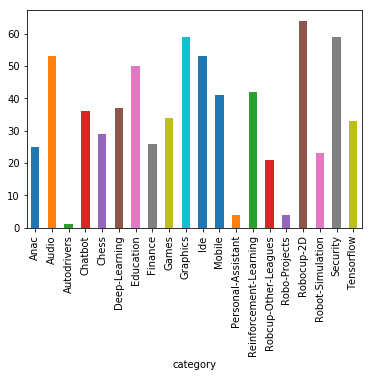

In [109]:
df.groupby('category').count()['type'].plot(kind='bar')

In [110]:
low = .01
high = .9816
quant_df = df['analizo_accm_mean'].quantile([low, high])
quant_df

1.00E-02   9.32E-01
9.82E-01   1.04E+01
Name: analizo_accm_mean, dtype: float64

In [137]:
print('before accm outlier cleaing : %s'%df.shape[0])
df_no_out =df.loc[df['analizo_accm_mean']<=quant_df[high]].copy()
print('after accm outlier cleaing : %s'%df_no_out.shape[0])
df_reduced= df_no_out[(df_no_out['year'].isnull()) | (df_no_out['year'] > 2000) ]
print('after removing repos older than 2001 : %s'%df_reduced.shape[0])
df_reduced =df_reduced[df_reduced['source_lang']!='C']
print('after removing C repos : %s'%df_reduced.shape[0])

before accm outlier cleaing : 694
after accm outlier cleaing : 681
after removing repos older than 2001 : 666
after removing C repos : 657


(1.5, 4.2013147930698)

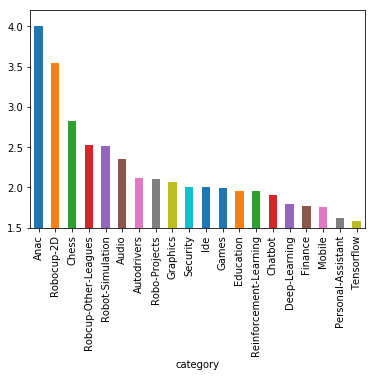

In [138]:
df_no_out.groupby('category').mean()['analizo_accm_mean'].sort_values(ascending=False).plot(kind='bar')
plt.ylim(ymin=1.5)

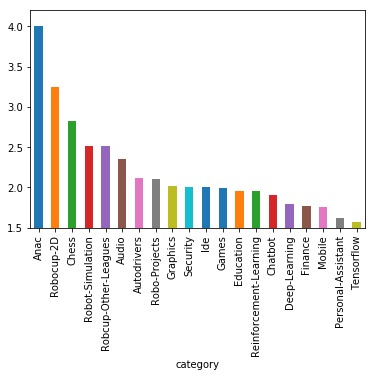

In [139]:
df_reduced.groupby('category').mean()['analizo_accm_mean'].sort_values(ascending=False).plot(kind='bar')
plt.ylim(ymin=1.5)
plt.savefig('../fig/accm_dist.eps',dpi=1200,format='eps')

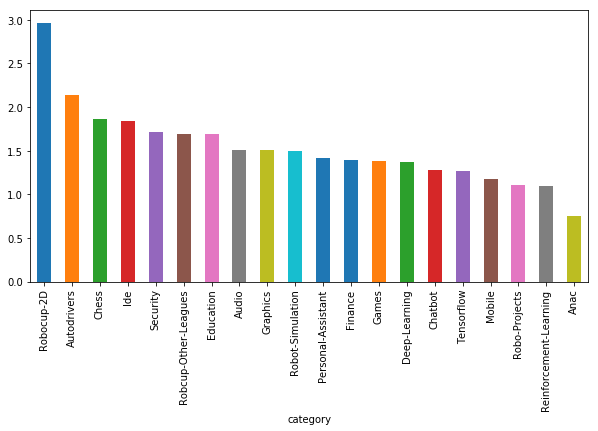

In [140]:
df_reduced.groupby('category').median()['analizo_acc_mean'].sort_values(ascending=False).plot(kind='bar',figsize=(10,5))

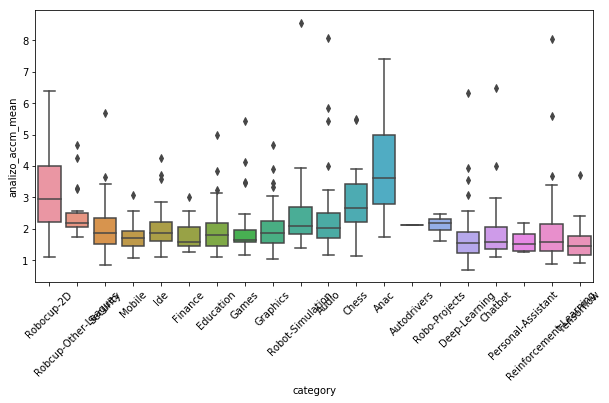

In [141]:
fix,ax = plt.subplots(figsize=(10,5),)
sns.boxplot(ax=ax,data=df_reduced,x='category',y='analizo_accm_mean')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [142]:
from scipy import stats
from operator import itemgetter

In [143]:
diff_vars = []
cat_lst = list(df_reduced[df_reduced['agent_type']=='agent']['category'].unique())
cat_lst.extend(df_reduced[df_reduced['agent_type']=='non-agent']['category'].unique())

In [144]:
variables = list(df_reduced.select_dtypes(include=[np.number]).columns)

In [145]:
diff_vars = {}
rep1= set()
for var in variables:
    ks_stats = []        
    
    for cat in cat_lst:
        rvs2 = df_reduced[(df_reduced['agent_type']=='non-agent')&(df_reduced['category']!=cat)][var]
        rvs1 = df_reduced[df_reduced['category']==cat][var]
        
        p = stats.ks_2samp(rvs1, rvs2)[1]
        if (p<0.005) and (rvs1.mean()>rvs2.mean()):
            ks_stats.append((cat,p))
        if len(ks_stats)>=3:
            
           
            cats , ps = zip(*ks_stats)
            rep1 |= set(cats)
            diff_vars[var] = [list(cats) ,sum(ps) / float(len(ps))]
            #sorted (ks_stats,key=itemgetter(1))
    

In [146]:
stat_df = pd.DataFrame.from_dict(diff_vars).transpose()
stat_df.columns = ['Repositories','p_value']
stat_df.p_value = stat_df.p_value.astype(float)
pd.set_option('display.float_format', '{:.2E}'.format)

In [147]:

stat_df.sort_values('p_value',inplace=True)

In [148]:
print(stat_df[0:15].to_latex())

\begin{tabular}{llr}
\toprule
{} &                                 Repositories &  p\_value \\
\midrule
analizo\_accm\_mean             &                    [Robocup-2D, Chess, Anac] & 8.14E-08 \\
analizo\_accm\_quantile\_upper   &                    [Robocup-2D, Chess, Anac] & 2.46E-06 \\
analizo\_amloc\_quantile\_lower  &                    [Robocup-2D, Chess, Anac] & 4.03E-05 \\
analizo\_accm\_quantile\_median  &                    [Robocup-2D, Chess, Anac] & 7.68E-05 \\
analizo\_amloc\_quantile\_upper  &  [Robocup-2D, Chess, Anac, Robot-Simulation] & 1.13E-04 \\
analizo\_loc\_quantile\_upper    &                    [Robocup-2D, Anac, Audio] & 1.65E-04 \\
analizo\_amloc\_mean            &  [Robocup-2D, Chess, Anac, Robot-Simulation] & 2.12E-04 \\
analizo\_noa\_kurtosis          &                  [Robocup-2D, Ide, Graphics] & 3.49E-04 \\
analizo\_noa\_skewness          &                  [Robocup-2D, Ide, Graphics] & 3.62E-04 \\
analizo\_mmloc\_quantile\_lower  &                    

In [149]:
diff_v = {k[k.find('_')+1:]: [ 1 if r in v[0] else 0 for r in rep1] +[v[1]] for k,v in diff_vars.iteritems()}
diff_v

{'accm_mean': [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 8.14160736405188e-08],
 'accm_quantile_median': [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 7.675453348798745e-05],
 'accm_quantile_upper': [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2.4565115013885986e-06],
 'accm_standard_deviation': [0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0.0014394343163145595],
 'amloc_mean': [0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0.0002117521012048528],
 'amloc_quantile_lower': [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 4.025998900592006e-05],
 'amloc_quantile_median': [0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0.0009471863384136561],
 'amloc_quantile_upper': [0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0.00011309433999071535],
 'anpm_quantile_lower': [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0.0015667753150717836],
 'anpm_quantile_max': [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0.000827163036715576],
 'anpm_quantile_upper': [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0.002377391219196021],
 'anpm_standard_deviation': [0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0.001

In [150]:
df =  pd.DataFrame.from_dict(diff_v,orient='index',columns=rep1|set(['p'])).sort_values('p')
df

,Audio,Robot-Simulation,Robocup-2D,Reinforcement-Learning,Deep-Learning,p,Chess,Graphics,Tensorflow,Ide,Anac
loc_mean,0,1,1,0,0,0,1,0,1,1,1.42E-03
anpm_quantile_lower,0,1,1,0,0,0,1,0,0,1,1.57E-03
noa_kurtosis,1,0,1,0,0,0,1,0,0,0,3.49E-04
anpm_quantile_max,0,0,1,0,1,0,1,0,0,0,8.27E-04
mmloc_quantile_upper,0,1,1,0,0,0,0,0,1,1,1.25E-03
anpm_variance,0,0,1,0,1,0,1,1,0,1,1.43E-03
anpm_quantile_upper,0,0,1,0,1,0,1,0,0,0,2.38E-03
loc_quantile_upper,0,0,1,0,0,0,0,0,1,1,1.65E-04
dit_skewness,0,0,0,1,1,0,1,0,0,0,2.12E-03
anpm_standard_deviation,0,0,1,0,1,0,1,1,0,1,1.43E-03


In [151]:
print(df[0:10].to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  Audio &  Robot-Simulation &  Robocup-2D &  Reinforcement-Learning &  Deep-Learning &  p &  Chess &  Graphics &  Tensorflow &  Ide &     Anac \\
\midrule
loc\_mean                &      0 &                 1 &           1 &                       0 &              0 &  0 &      1 &         0 &           1 &    1 & 1.42E-03 \\
anpm\_quantile\_lower     &      0 &                 1 &           1 &                       0 &              0 &  0 &      1 &         0 &           0 &    1 & 1.57E-03 \\
noa\_kurtosis            &      1 &                 0 &           1 &                       0 &              0 &  0 &      1 &         0 &           0 &    0 & 3.49E-04 \\
anpm\_quantile\_max       &      0 &                 0 &           1 &                       0 &              1 &  0 &      1 &         0 &           0 &    0 & 8.27E-04 \\
mmloc\_quantile\_upper    &      0 &                 1 &           1 &                       0 &              0 

In [152]:
df_reduced['agent_cat'] = pd.Categorical(df_reduced['agent_type'],['agnet','Robot','non-agent'])
df_reduced.sort_values('agent_cat',inplace=True)

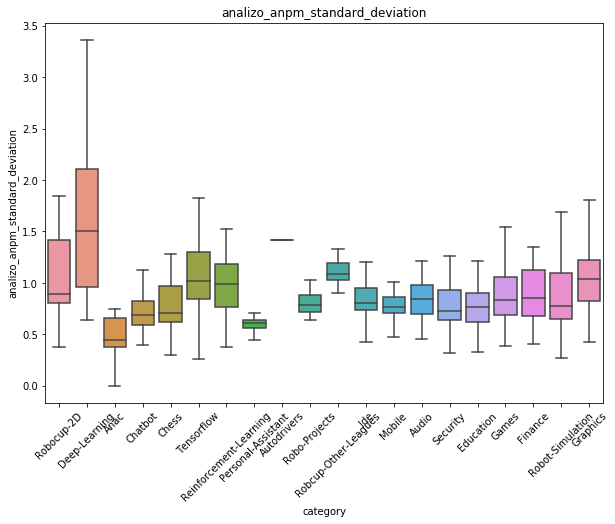

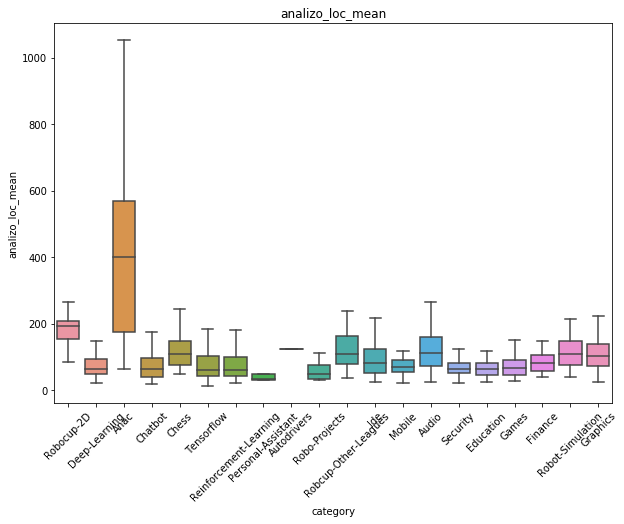

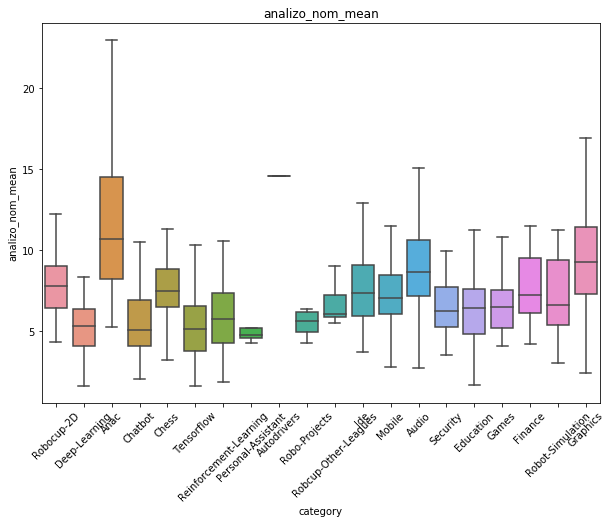

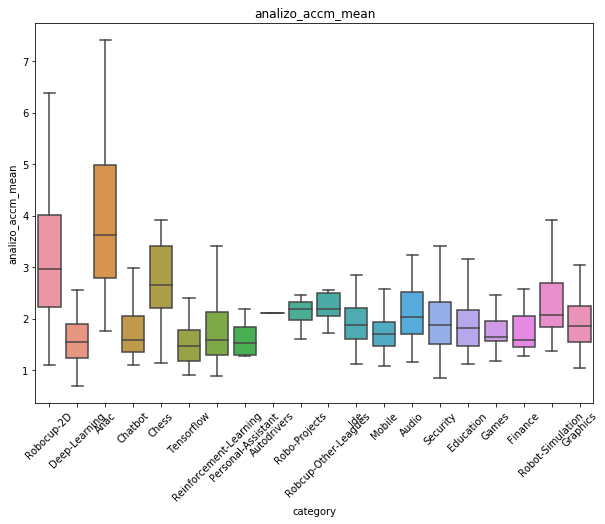

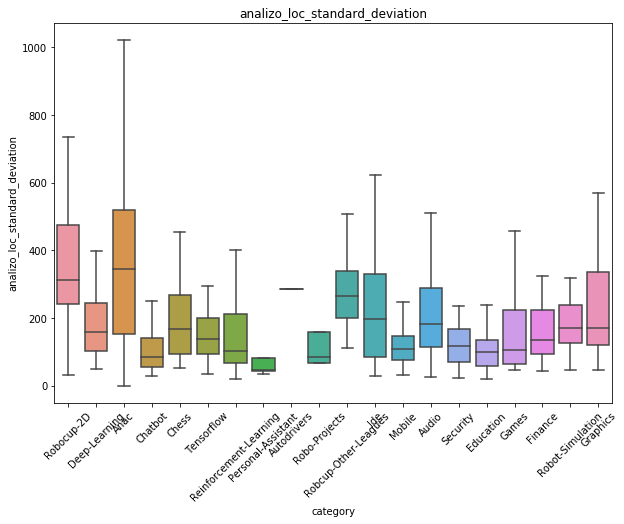

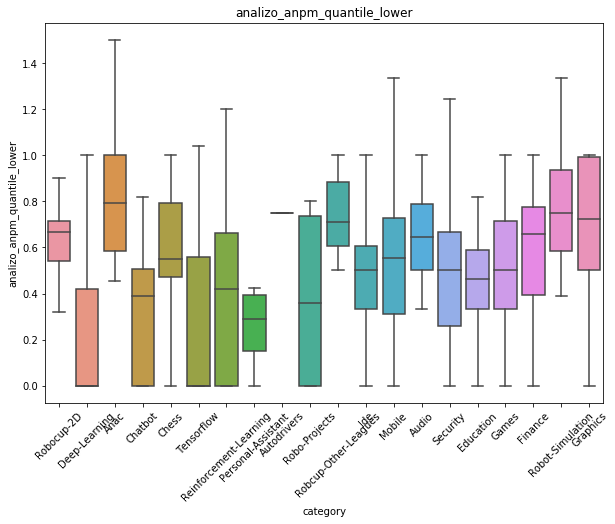

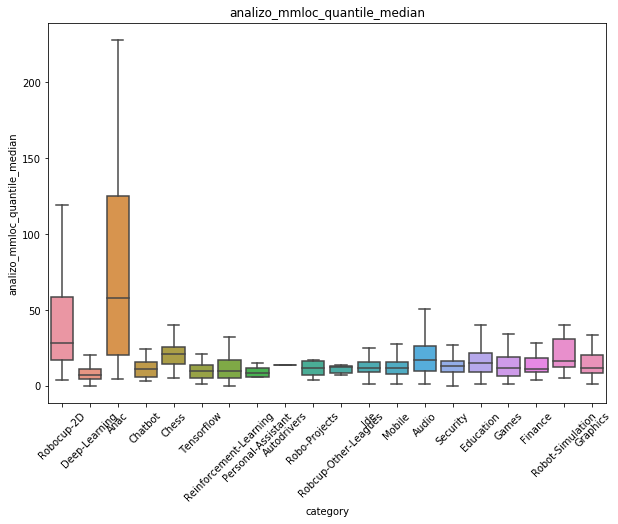

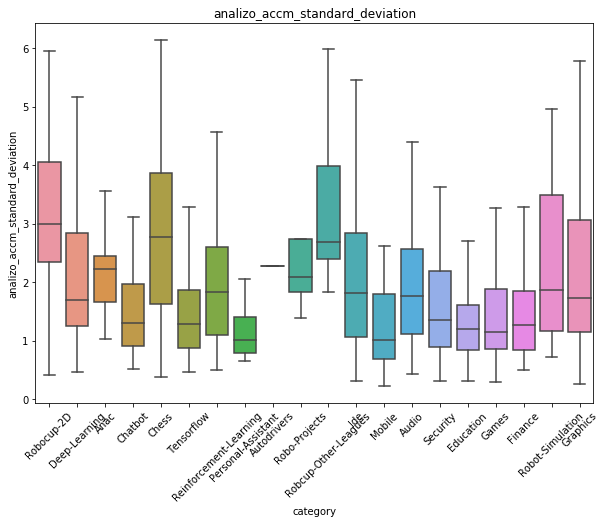

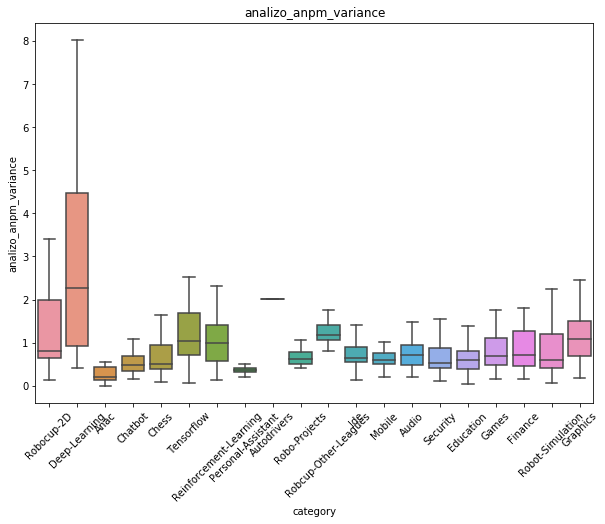

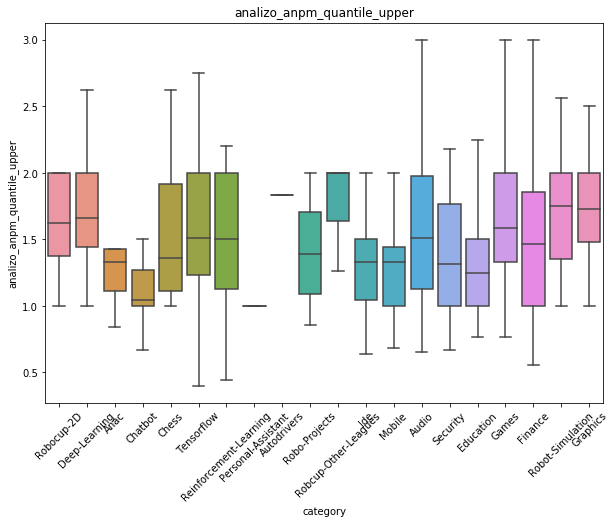

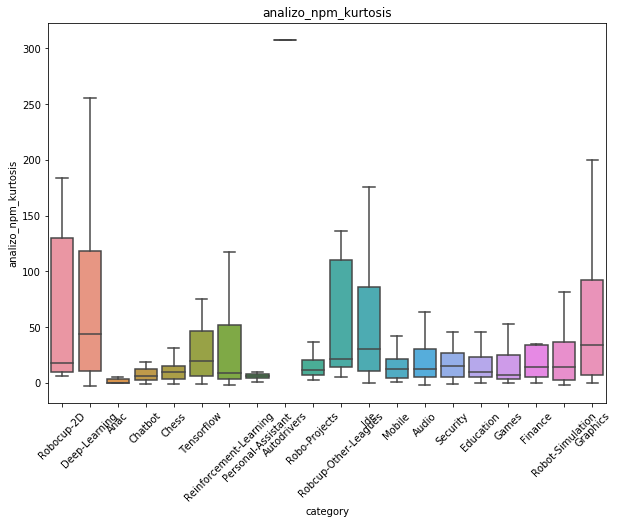

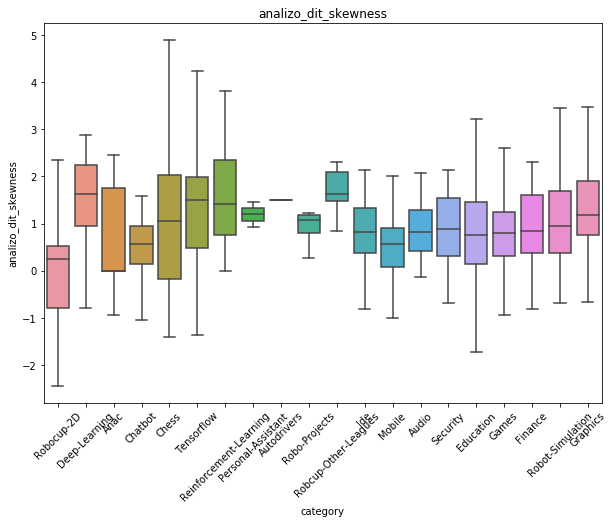

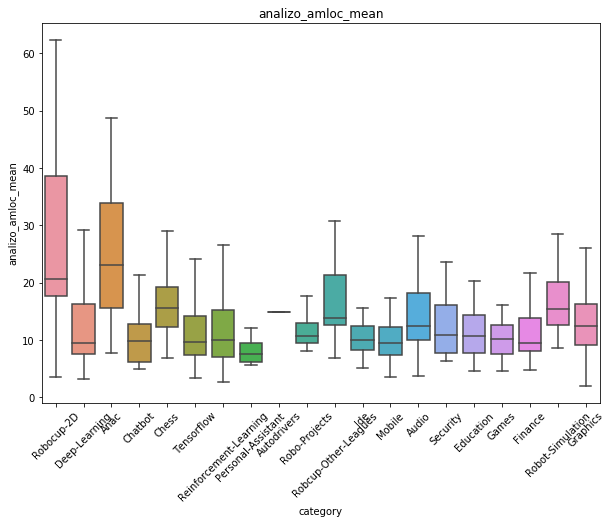

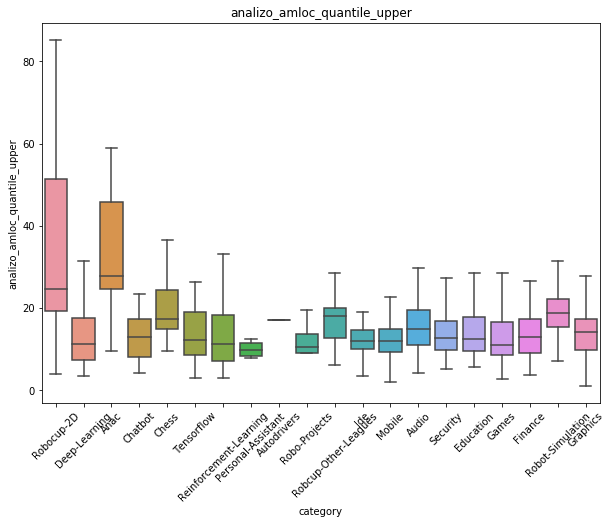

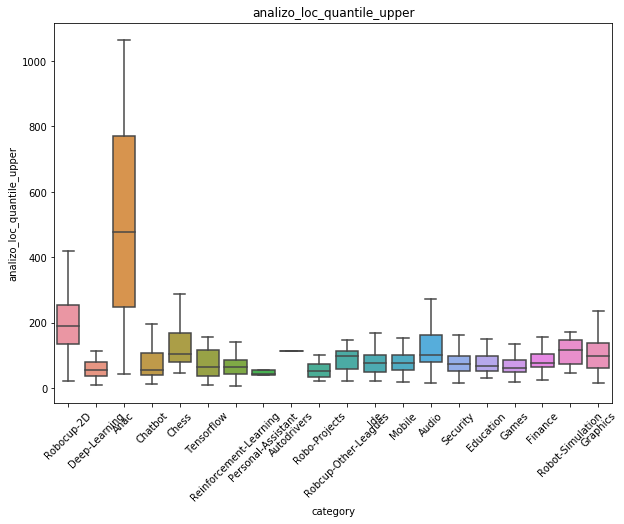

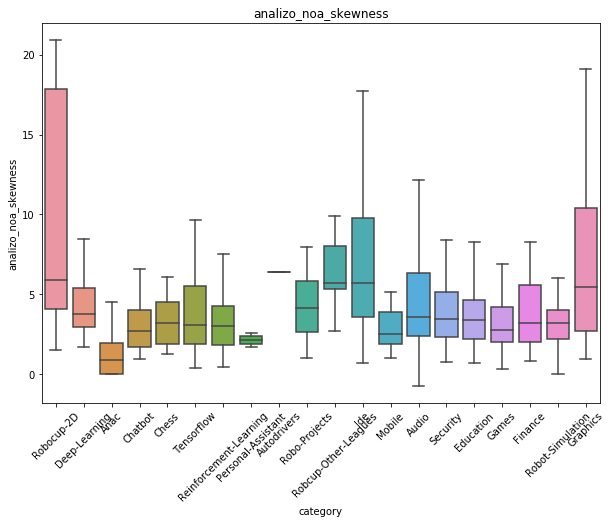

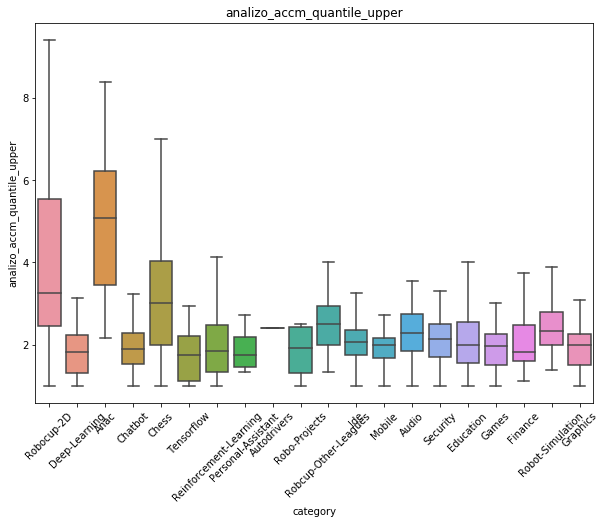

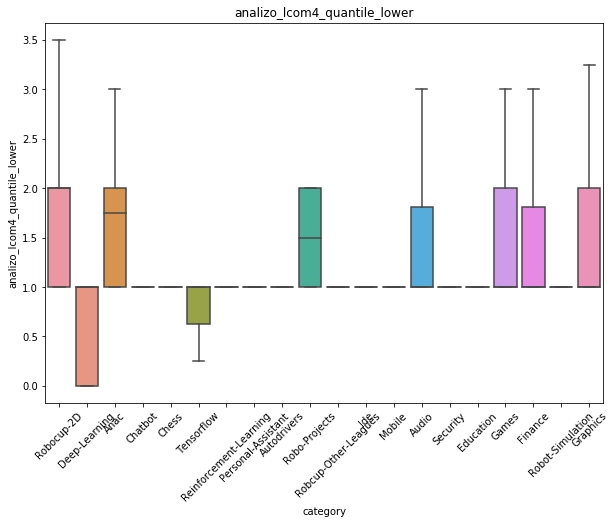

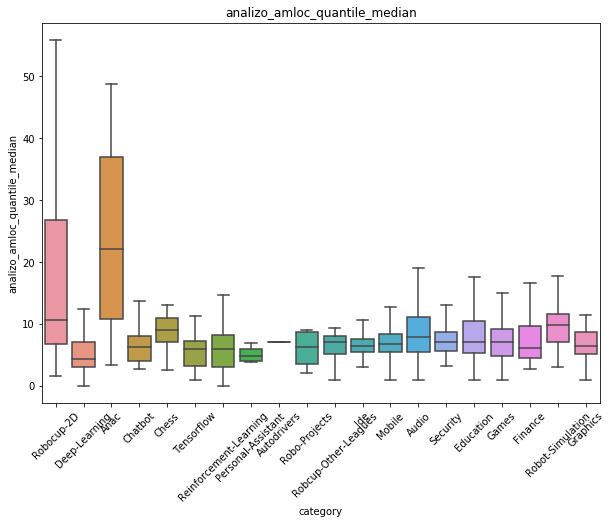

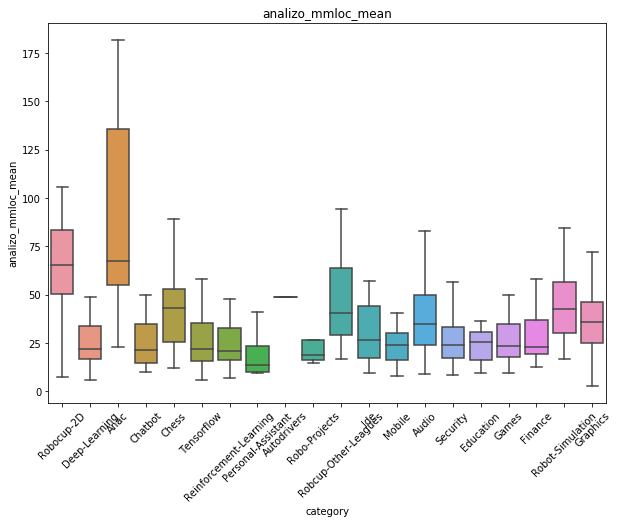

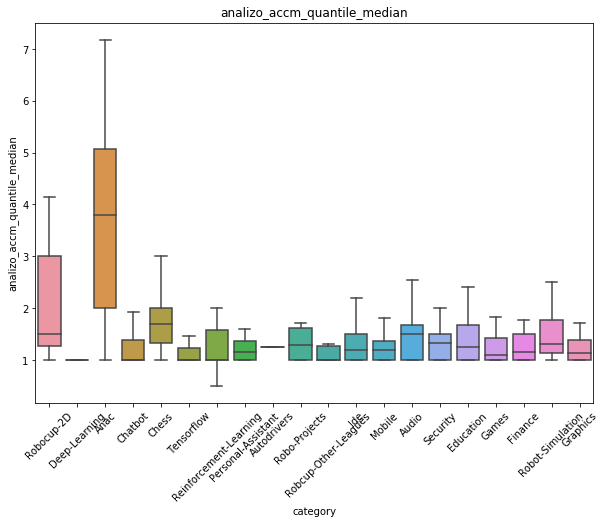

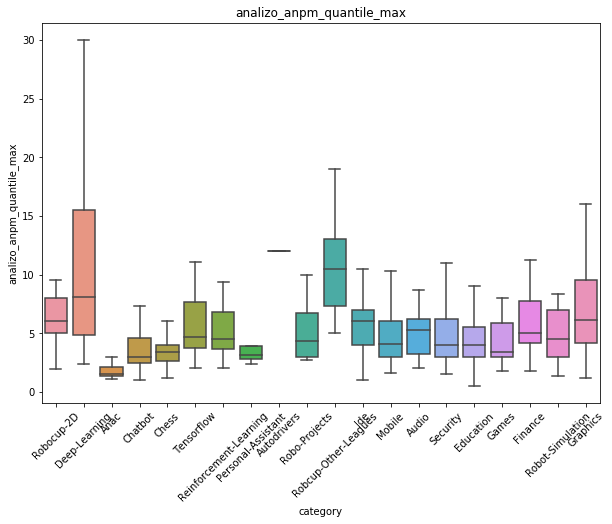

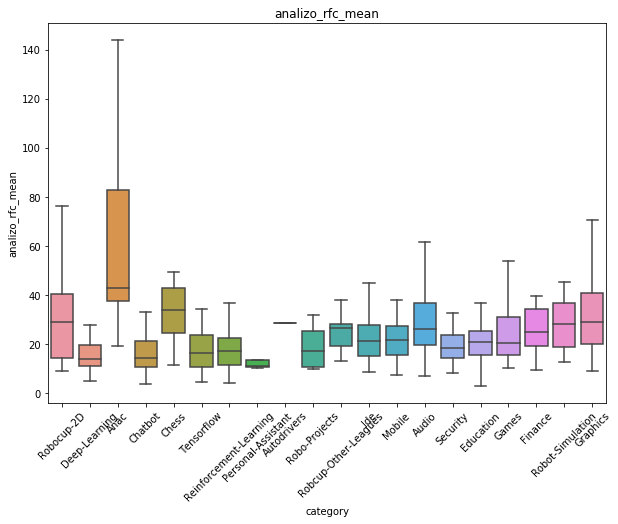

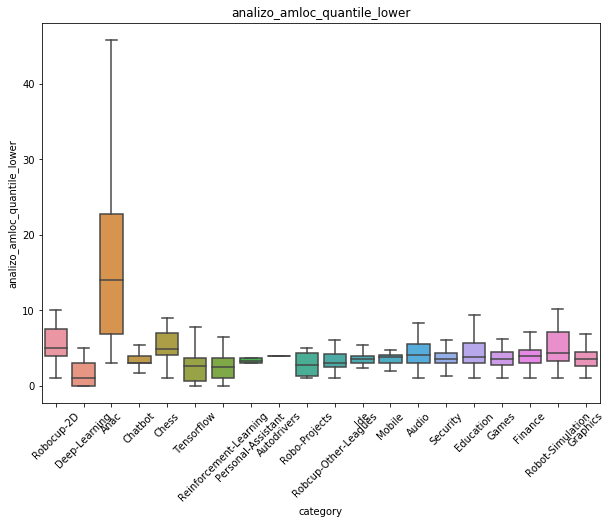

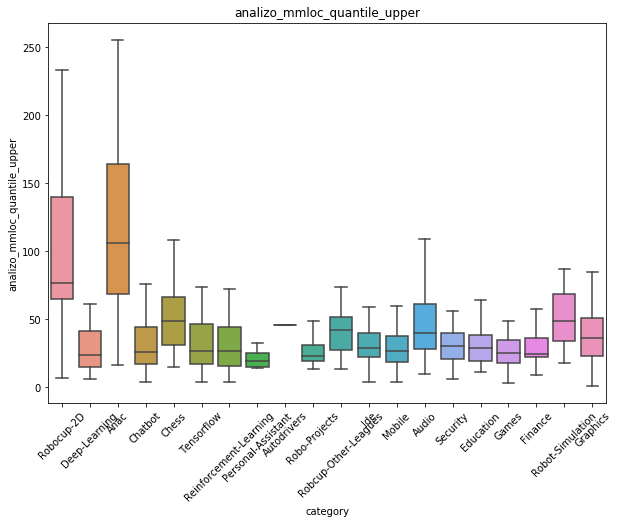

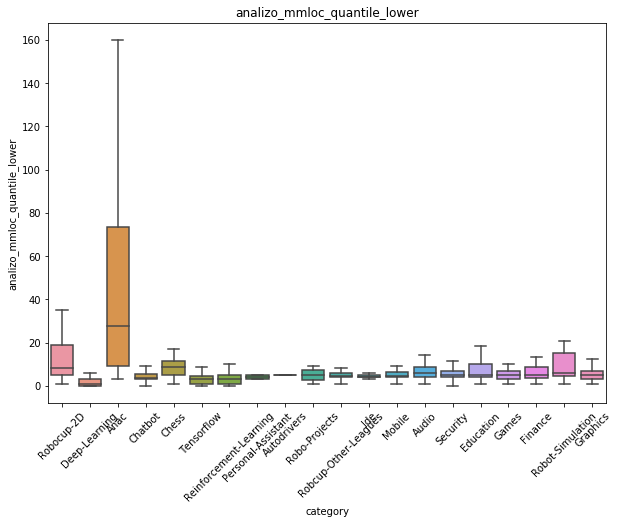

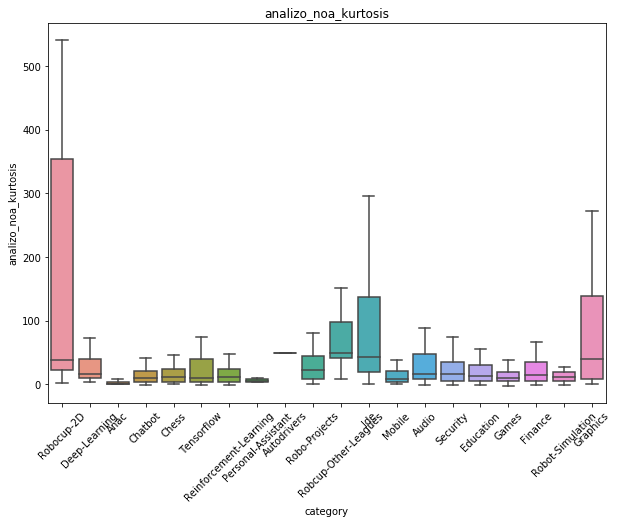

In [153]:
for var in diff_vars:
    
    fix,ax = plt.subplots(figsize=(10,7),)
    sns.boxplot(x='category',y=var,data=df_reduced,showfliers=False).set_title(var)
    #g = sns.swarmplot(x='category',y=var,data=df_reduced,color='black')
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.savefig('../fig/box_plot_category_vs_metric%s.eps'%var,dpi=1200,format='eps')
    plt.show()
            

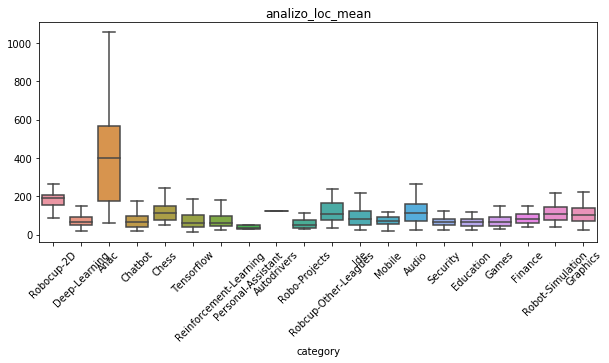

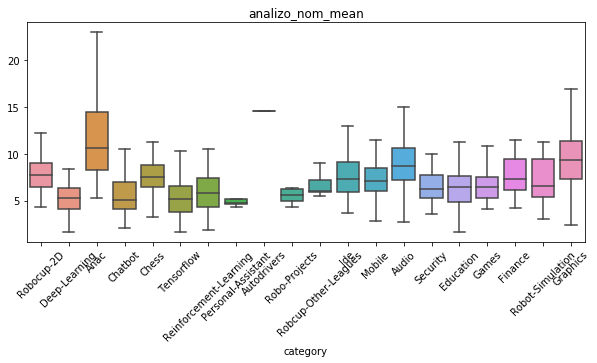

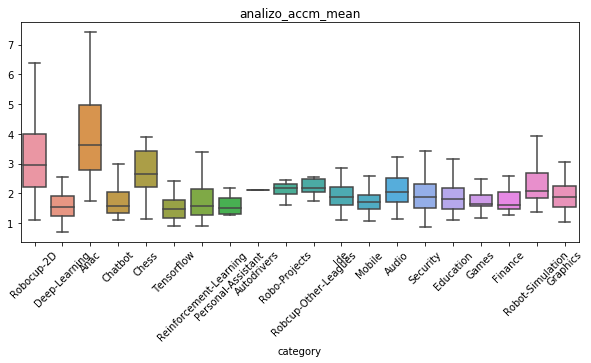

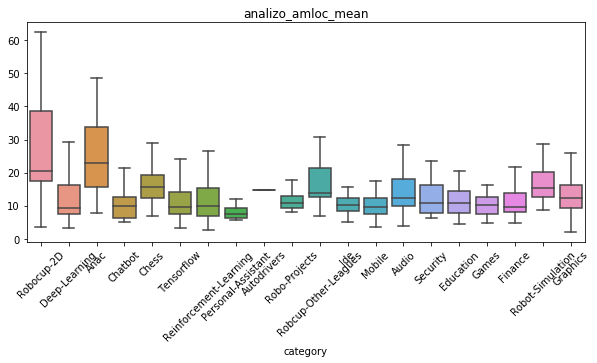

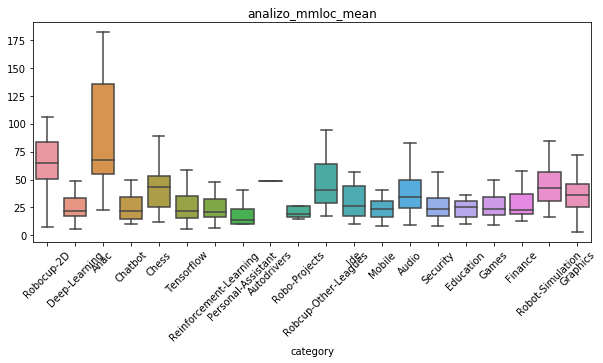

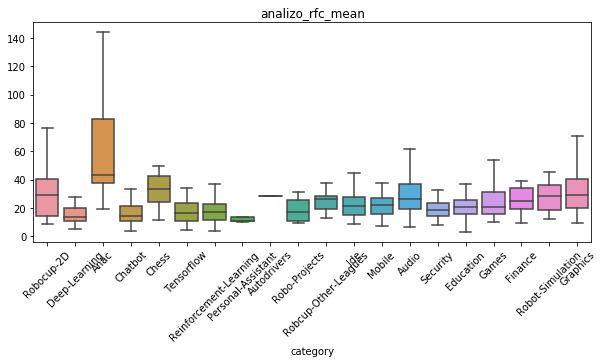

In [155]:
for var in [c for c in diff_vars if 'mean'  in c]:
    
    fix,ax = plt.subplots(figsize=(10,5),)
    sns.boxplot(ax=ax , x='category',y=var,data=df_reduced,showfliers=False).set_title(var)
    plt.gcf().subplots_adjust(bottom=0.27)
    #g = sns.swarmplot(x='category',y=var,data=df_reduced,color='black')
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    x_axis = ax.axes.get_yaxis()
    x_axis.set_label_text('foo')
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    plt.savefig('../fig/'+var+"_output.eps",dpi=1200,format='eps')


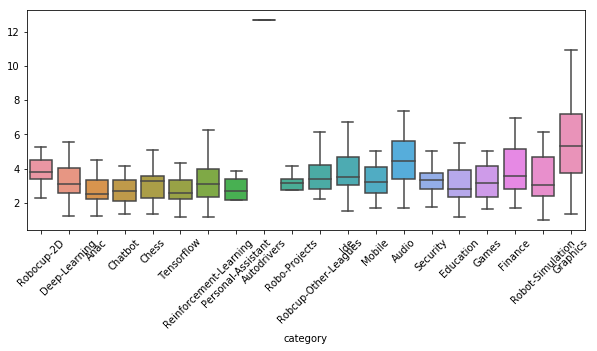

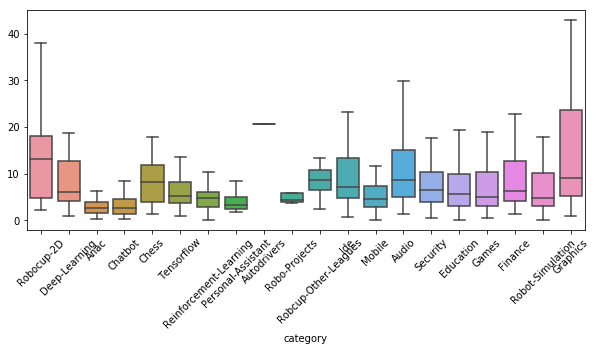

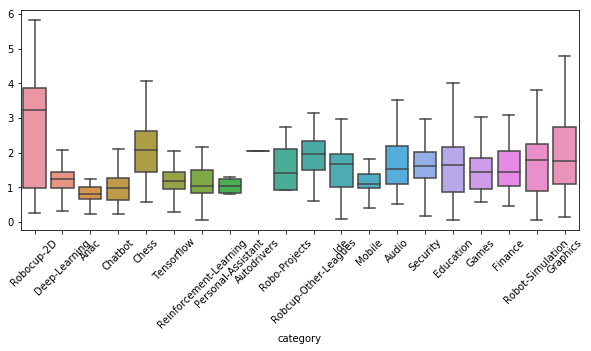

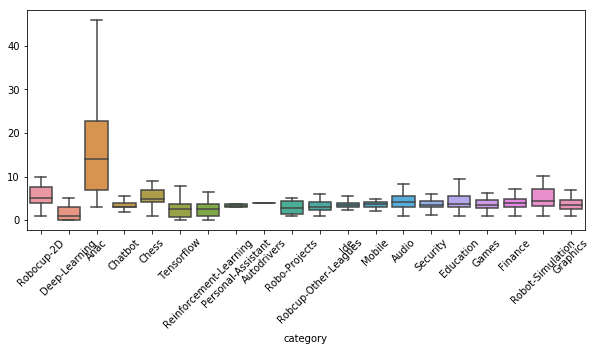

In [156]:
features = ["analizo_lcom4_mean",'analizo_sc_mean','analizo_cbo_mean','analizo_amloc_quantile_lower']


for var in features:
    
    fix,ax = plt.subplots(figsize=(10,5),)
    sns.boxplot(ax=ax , x='category',y=var,data=df_reduced,showfliers=False)
    plt.gcf().subplots_adjust(bottom=0.27)
    #g = sns.swarmplot(x='category',y=var,data=df_reduced,color='black')
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    x_axis = ax.axes.get_yaxis()
    x_axis.set_label_text('foo')
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    plt.savefig('../fig/'+var+"_output.eps",dpi=1200,format='eps')



In [157]:
df2 =  pd.read_csv(os.getcwd() +"/data/robo-sim-data.csv",index_col=0)

IOError: File /Users/azanbar/code/studies/robocup_analysis/external/data/robo-sim-data.csv does not exist

In [158]:
df2 = df2[~df2['McCabes_cyclomatic_complexity'].isnull()].copy()

NameError: name 'df2' is not defined

In [ ]:
df2['cc_per_line_of_code'] = df2['McCabes_cyclomatic_complexity'] / df2['analizo_total_loc']

In [ ]:
df2['McCabes_cyclomatic_complexity'].hist(range=(0,2500))

In [ ]:
df2.plot.scatter(x='analizo_accm_mean',y='cc_per_line_of_code' )
plt.ylim(0,1)